In [27]:
# Imports
import os

# Data science and vis tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Nilearn: Python module for statistical processing of neuroimaging data.
from nilearn import datasets, plotting, image, interfaces

# NiftiMasker is for single regoin of interest
# NiftiMapsMasker is for probablistic atlas
# NiftiLabelsMasker is for discrete atlas
from nilearn.maskers import NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker 

import nibabel as nib # Read and write access to common neuroimaging file formats
import nitime as nit # library for the analysis of time series in the field of neuroimaging. 

## Get Cleaned Data

**Copy code block below to get cleaned data**

In [15]:
import pandas as pd
import numpy as np
from ast import literal_eval # Gets network matrix array from csv 
import re

data = pd.read_csv('Data/data_clean.csv', index_col = 'subject_id', 
            converters = {'netmat' : lambda x : np.array(literal_eval(re.sub('(?<!\[)\s+|[\\n]', ', ', x)))})

In [16]:
data.head()

,Gender,Age,netmat
subject_id,,,
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."


## KNN Implementation

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [18]:
X = data['netmat'].apply(lambda x : x.flatten()).to_list()
y = data['Gender'].to_list()

In [19]:
# Generate Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [20]:
# Knn classifier
knn10 = KNeighborsClassifier(n_neighbors = 10)

In [21]:
knn10.fit(X_train, y_train)
y_pred_2 = knn10.predict(X_test)

In [22]:
print("Accuracy with k=10", accuracy_score(y_test, y_pred_2)*100)

Accuracy with k=10 70.5179282868526


In [23]:
# Test different n
for i in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print("Accuracy with k=" + str(i), accuracy_score(y_test, y_pred)*100)

Accuracy with k=1 65.33864541832669
Accuracy with k=2 71.71314741035857
Accuracy with k=3 64.14342629482071
Accuracy with k=4 70.91633466135458
Accuracy with k=5 63.34661354581673
Accuracy with k=6 70.1195219123506
Accuracy with k=7 64.14342629482071
Accuracy with k=8 70.91633466135458
Accuracy with k=9 64.9402390438247
Accuracy with k=10 70.5179282868526
Accuracy with k=11 66.53386454183267
Accuracy with k=12 69.32270916334662
Accuracy with k=13 63.34661354581673
Accuracy with k=14 67.72908366533864
Accuracy with k=15 62.54980079681275
Accuracy with k=16 67.72908366533864
Accuracy with k=17 65.33864541832669
Accuracy with k=18 68.12749003984064
Accuracy with k=19 66.13545816733067
Accuracy with k=20 68.52589641434263
Accuracy with k=21 66.53386454183267
Accuracy with k=22 67.33067729083665
Accuracy with k=23 64.9402390438247
Accuracy with k=24 68.52589641434263


**71 percent accuracy not bad but the n does not make a difference**

## Import Atlas

What is melodic FSL?

Melodic is the tool in FSL that we use at both the subject and group level to decompose FMRI data into time-courses and spatial maps using ICA. Dual regression is a tool that we can use as part of a group-level resting state analysis to identify the subject-specific contributions to the group level ICA.

MELODIC (Multivariate Exploratory Linear Optimized Decomposition into Independent Components) analysis. MELODIC is a tool used for independent component analysis (ICA) in functional magnetic resonance imaging (fMRI) data.

In [31]:
melodic_sum_file = 'Data/HCP/melodic_IC_sum.nii.gz' # Nifti 4D Data

Plots the different regions in the atlas

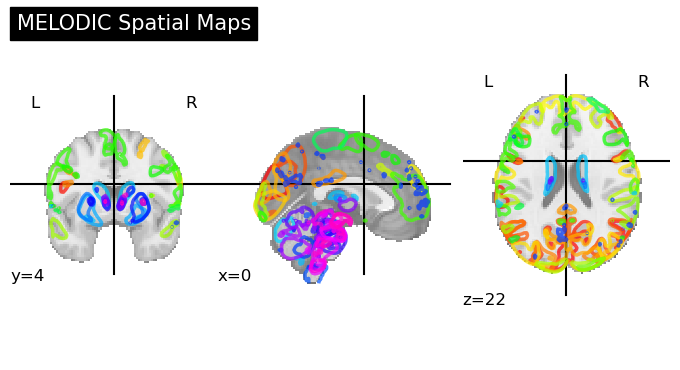

In [32]:
# Load Image
melodic_img = image.load_img(melodic_sum_file)

# Plot melodic spatial maps
plotting.plot_prob_atlas(melodic_img, title='MELODIC Spatial Maps')

### Andrew's Data

Get confounds and compute redisuals

In [37]:
andrew_file = 'Data/subject_Andrew/sub-00_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz'

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

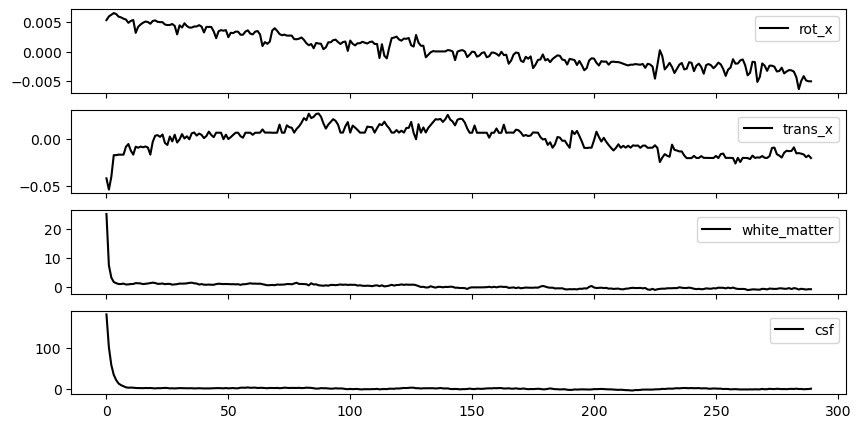

In [38]:
n_drop = 0

img = image.load_img(andrew_file) # Load my file

# get fMRIPrep calculated confounds
confounds = interfaces.fmriprep.load_confounds_strategy(andrew_file, denoise_strategy="simple")[0]

confounds.loc[n_drop:, ["rot_x", "trans_x", "white_matter", "csf"]].plot(
    kind="line", subplots=True, sharex=True, sharey=False, figsize=(10, 5), color="k"
)

In [41]:
masker = NiftiMapsMasker(
    maps_img=melodic_sum_file,
    smoothing_fwhm=6,  # gaussian kernel width (in mm)
    standardize="zscore_sample",  # zero mean, unit variance
    standardize_confounds="zscore_sample",
)

In [42]:
# residuals of OLS, drop first `n_drop` timepoints
time_series = masker.fit_transform(andrew_file, confounds=confounds)[n_drop:, :]
time_series.shape

(290, 100)

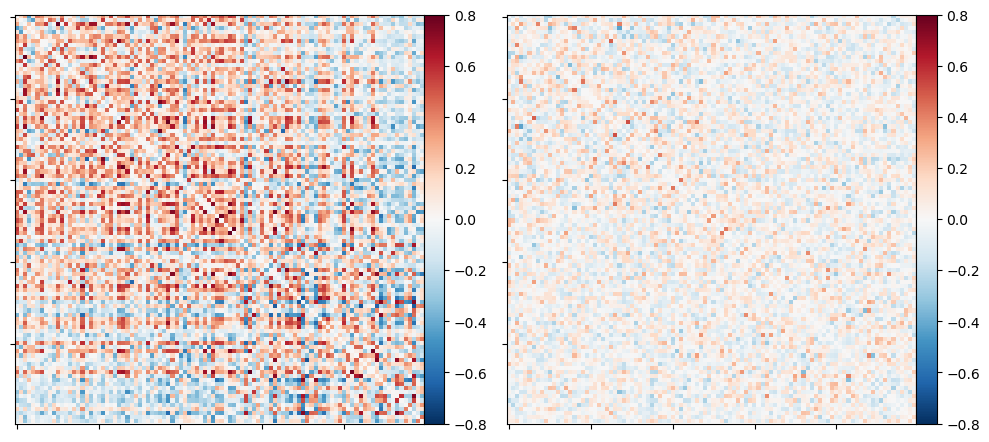

In [58]:
# pairwise correlations
X_corr = time_series.T @ time_series / (time_series.shape[0] - 1)

# partial correlations
# https://en.wikipedia.org/wiki/Partial_correlation#Using_matrix_inversion
X_inv = np.linalg.inv(X_corr)
X_pcorr = -X_inv / np.outer(np.sqrt(np.diag(X_inv)), np.sqrt(np.diag(X_inv)))

# Fill Diagonal to zero
np.fill_diagonal(X_corr, 0)
np.fill_diagonal(X_pcorr, 0)

# plot matrices
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
kwargs = dict(vmin=-0.8, vmax=0.8, colorbar=True)
plotting.plot_matrix(X_corr, axes=axs[0], **kwargs)
plotting.plot_matrix(X_pcorr, axes=axs[1], **kwargs) # Change so more readable

Positive Correlation


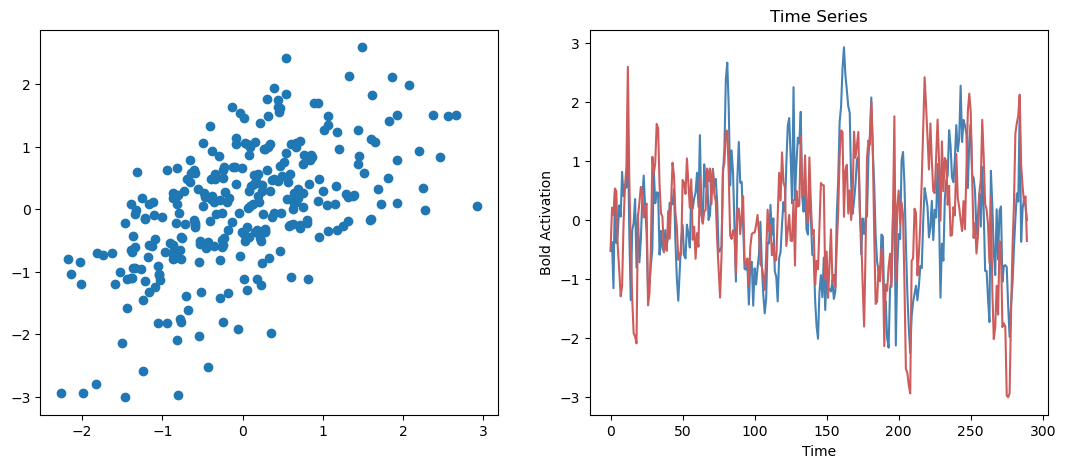

In [44]:
# Two correlated regions
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].scatter(time_series[:,2], time_series[:,12])

axes[1].plot(time_series[:,2], c = 'steelblue')
axes[1].plot(time_series[:,12], c = 'indianred')
axes[1].set(xlabel ='Time', ylabel = 'Bold Activation', title ='Time Series')

print('Positive Correlation')

**Fisher Transformation**

In [45]:
# Check if Valid
sum(np.isnan(np.arctanh(X_pcorr).flatten()))

0

In [74]:
X_pcorr_trans = np.arctanh(X_pcorr)
X_pcorr_trans[2]

array([ 0.0111835 ,  0.15349591,  0.        ,  0.32499202,  0.14836444,
       -0.0702563 ,  0.06465211,  0.41533526,  0.01903741, -0.04867984,
        0.28906791,  0.22350744,  0.12014799, -0.06651879, -0.23530856,
        0.12523496, -0.11012651, -0.11320954,  0.17285808,  0.10428762,
        0.01129839, -0.07233187, -0.00163654,  0.08651561,  0.1042558 ,
        0.13456525,  0.00992299,  0.42659009,  0.07804496,  0.12296766,
       -0.05935978,  0.22500214, -0.06591572, -0.03932712, -0.15653805,
        0.01890081, -0.17348551,  0.17689762,  0.0988987 ,  0.20416551,
        0.14419377, -0.22202819, -0.26976841,  0.00515828, -0.09264186,
       -0.28561419, -0.11241807, -0.1400089 , -0.02875294, -0.01508117,
       -0.10979447, -0.01055512,  0.02758087,  0.23415397,  0.05274674,
       -0.00987197,  0.15019497,  0.17259661, -0.02548313,  0.00179944,
       -0.0027416 ,  0.14223942, -0.098112  ,  0.25321309, -0.07677211,
       -0.10142518, -0.05269882,  0.04032999, -0.09709877, -0.10

In [75]:
# Norm of difference
np.linalg.norm(X_pcorr_trans - X_pcorr)

0.2378959490206484

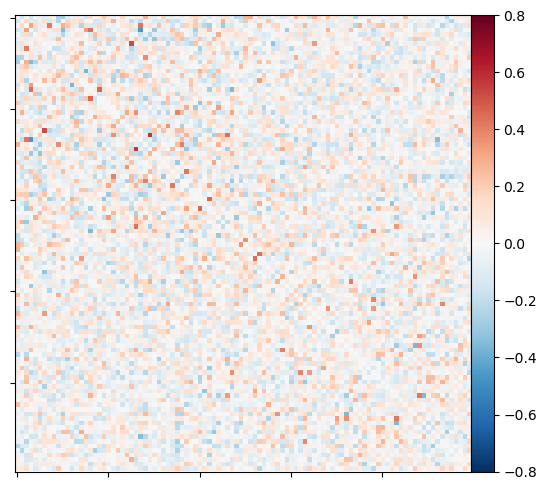

In [76]:
plotting.plot_matrix(X_pcorr_trans, **kwargs)

**Test with Knn Implementation**

In [77]:
# Verify if my parents lied to me my whole life
knn10.predict([X_corr_trans.flatten()])

array(['M'], dtype='<U1')

In [78]:
distance, index = knn10.kneighbors([X_corr_trans.flatten()], 10)

In [79]:
index

array([[304, 293, 634, 680, 746, 512,  17, 116, 736, 112]])

In [80]:
data.iloc[index[0]]

,Gender,Age,netmat
subject_id,,,
167238,F,31-35,"[[0.0, -2.3993, 10.596, -5.4911, 0.96779, 1.54..."
164131,M,26-30,"[[0.0, 1.8545, 5.7677, -7.9214, 2.0375, 3.2989..."
394956,F,26-30,"[[0.0, 0.63118, 3.8305, -9.4109, -1.0076, 0.15..."
497865,M,26-30,"[[0.0, 1.0657, 13.45, -9.8745, 2.4048, 1.654, ..."
581349,M,31-35,"[[0.0, -0.13866, 11.302, -7.3669, 1.7165, 3.68..."
217429,F,31-35,"[[0.0, -0.21987, 7.5397, -7.0956, -1.3416, -2...."
103212,M,31-35,"[[0.0, 0.74537, 6.7713, -5.8234, 2.062, 2.5828..."
127226,M,22-25,"[[0.0, -2.3686, 14.18, -13.078, -1.2789, 4.684..."
573249,M,26-30,"[[0.0, 0.31674, 15.541, -11.894, 1.5586, 2.456..."


**Plot the brain**

In [52]:
# Display my big brain (Mean Image)
mean_img = image.mean_img(andrew_file) # The mean of the Time Series Data

In [53]:
component_img = masker.inverse_transform(np.ones(100))

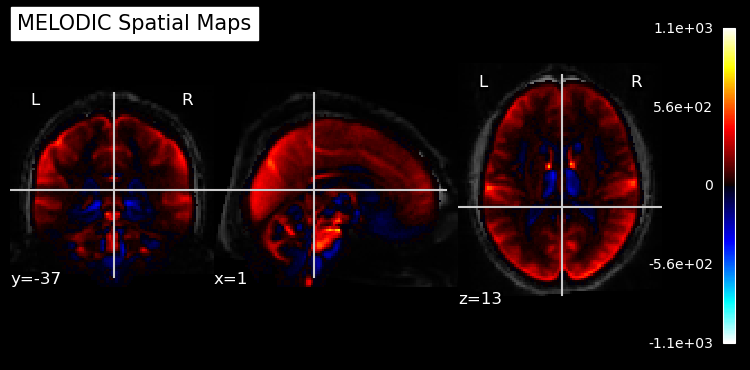

In [54]:
plotting.plot_stat_map(component_img, mean_img, title='MELODIC Spatial Maps')